### Вводные
Бизнес-задача - компания провела два независимых эксперимента по увеличению CTR. Предварительно t-тест не дал нужного значения
P-value ни в одном из экпериментов. Редизайн эксперимента и повторный запуск проводить не будут. Заказчик хочет знать, какой эксперимент стоит раскатывать.

Вместо того, чтобы заталкивать в тест «поюзерные» CTR, можно сконструировать другую метрику и анализировать ее, но при этом гарантируется (в отличие от сглаженного CTR), что если тест на этой другой метрике «прокрасится» и увидит изменения, значит изменения есть и в метрике исходной (то есть в лайках на пользователя и в пользовательских CTR).<br> Метод назвывается - линеаризация, и делается так:
* Посчитаю общий CTR в контрольной группе  𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙=𝑠𝑢𝑚(𝑙𝑖𝑘𝑒𝑠)/𝑠𝑢𝑚(𝑣𝑖𝑒𝑤𝑠) 
* Посчитаю в обеих группах поюзерную метрику  𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠=𝑙𝑖𝑘𝑒𝑠−𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙∗𝑣𝑖𝑒𝑤𝑠 
* После чего сравню t-тестом отличия в группах по метрике 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠

In [ ]:
import configparser

import pandas as pd
import seaborn as sns
import numpy as np

import pandahouse

import matplotlib.pyplot as plt


from scipy import stats

%matplotlib inline

In [2]:
config = configparser.ConfigParser()
config.read('config.ini')

['config.ini']

In [5]:
# Подсоединяемся к нужной базе данных.
# Логины, пароли и прочее в отдельном файле
connection = {
    'host': config.get('clickhouse_connection', 'host'),
    'user': config.get('clickhouse_connection', 'user'),
    'password': config.get('clickhouse_connection', 'password'),
    'database': config.get('clickhouse_connection', 'database')
}

### Первый эксперимент

In [6]:
#Выгружаем из базы данных уже сформированный датафрейм для экспериментальных групп 1 и 2
#первого эксперимента.
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-05-01' and '2023-05-07'
    and exp_group in (1, 2)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)


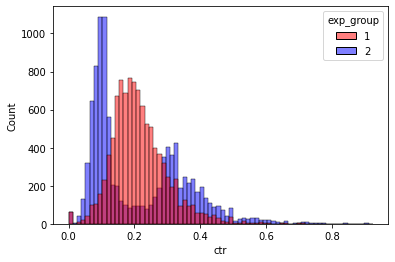

In [11]:
# Посмотрю как распределились эекспериментальные данные.
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [12]:
stats.ttest_ind(df[df.exp_group == 1].ctr,
               df[df.exp_group == 2].ctr,
               equal_var=False)

Ttest_indResult(statistic=0.7094392041270486, pvalue=0.4780623130874935)

P-value = 0.47. T-тест различий не нашел. С учетом распределения - неудивительно.

#### Расчет значений при помощи линеаризации.

In [13]:
global_ctr_control = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()


In [14]:
df["linearized"] = np.nan # создаю столбец с NaN

exp_group_1 = df[df.exp_group == 1]
exp_group_2 = df[df.exp_group == 2]

exp_group_1["linearized"] = exp_group_1.likes - (global_ctr_control * exp_group_1.views)
exp_group_2["linearized"] = exp_group_2.likes - (global_ctr_control * exp_group_2.views)
df = pd.concat([exp_group_1, exp_group_2]) # объединяю две группы

/tmp/ipykernel_49/2489277878.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_group_1["linearized"] = exp_group_1.likes - (global_ctr_control * exp_group_1.views)
/tmp/ipykernel_49/2489277878.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_group_2["linearized"] = exp_group_2.likes - (global_ctr_control * exp_group_2.views)


In [15]:
df.head()

,exp_group,user_id,likes,views,ctr,linearized
0,1,109963,3,15,0.200000,-0.120402
1,1,26117,32,141,0.226950,2.668221
2,1,138232,18,73,0.246575,2.814043
3,1,26295,33,122,0.270492,7.620730
4,1,18392,7,32,0.218750,0.343142


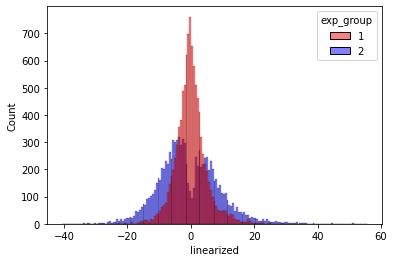

In [16]:
groups = sns.histplot(data = df, 
              x='linearized', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

#### Промежуточные результаты
Метод приобразования дал требуемый эффект. Видно, что распределение тестовой группы "2" стало выглядеть куда приятней.

##### Теперь посмотрю, что покажут Т-тест и Манн-Уитни
P.S. Линеаризация работает только для t-теста и родственных ему методов. Для Манна-Уитни никаких гарантий нет, но посмотреть интересно.

In [17]:
stats.ttest_ind(df[df.exp_group == 1].linearized,
               df[df.exp_group == 2].linearized,
               equal_var=False)

Ttest_indResult(statistic=6.122579994775972, pvalue=9.439432187037815e-10)

In [ ]:
stats.mannwhitneyu(df[df.exp_group == 1].linearized, 
                   df[df.exp_group == 2].linearized,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=54534537.0, pvalue=9.404319579641738e-27)

#### Результаты первого экспермента
Оба теста показали статистически значимые различия. Как мы помним, применение т-теста на "чистых" данных не показало нам разницы между распределениями как раз из-за "сложной" формы распределения тестовой группы. 

### Второй эксперимент

In [19]:
#Выгружаем из базы данных уже сформированный датафрейм для экспериментальных групп 0 и 3
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-05-01' and '2023-05-07'
    and exp_group in (0, 3)
GROUP BY exp_group, user_id
"""

df_0_3 = pandahouse.read_clickhouse(q, connection=connection)


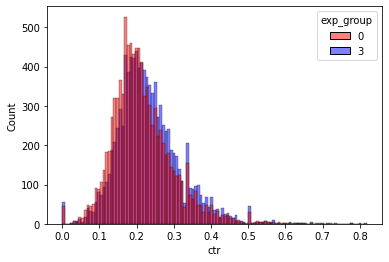

In [23]:
# Посмотрю как распределились эекспериментальные данные.
groups = sns.histplot(data = df_0_3, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [25]:
stats.ttest_ind(df_0_3[df_0_3.exp_group == 0].ctr,
               df_0_3[df_0_3.exp_group == 3].ctr,
               equal_var=False)

Ttest_indResult(statistic=-13.896870721904069, pvalue=1.055849414662529e-43)

P-value = 1.05е-43. T-тест стат. значимые различия нашел.

In [27]:
global_ctr_control_0 = df_0_3[df_0_3.exp_group == 0].likes.sum()/df_0_3[df_0_3.exp_group == 0].views.sum()

In [28]:
df_0_3.head(2)

,exp_group,user_id,likes,views,ctr,linearized
2,0,4944,8,41,0.195122,-0.537681
3,0,4504,5,15,0.333333,1.876458


In [29]:
df_0_3["linearized"] = np.nan # создаю столбец с NaN

exp_group_1 = df_0_3[df_0_3.exp_group == 0]
exp_group_2 = df_0_3[df_0_3.exp_group == 3]

exp_group_1["linearized"] = exp_group_1.likes - (global_ctr_control_0 * exp_group_1.views)
exp_group_2["linearized"] = exp_group_2.likes - (global_ctr_control_0 * exp_group_2.views)
df_0_3 = pd.concat([exp_group_1, exp_group_2]) # объединяю две группы

/tmp/ipykernel_49/1625634842.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_group_1["linearized"] = exp_group_1.likes - (global_ctr_control_0 * exp_group_1.views)
/tmp/ipykernel_49/1625634842.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_group_2["linearized"] = exp_group_2.likes - (global_ctr_control_0 * exp_group_2.views)


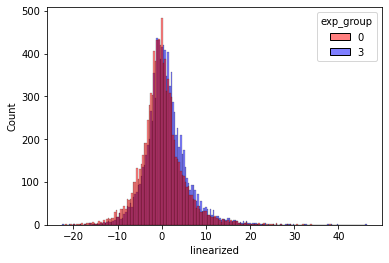

In [30]:
groups = sns.histplot(data = df_0_3, 
              x='linearized', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

#### Промежуточные результаты 
Такое представление для групп 0 и 3 дает визуализация распределений после линеаризации. Отчетливо видно, что тестовое распределение смещено вправо относительно контрольного.<br> Также можно сравнить разницу между визаулизацией с линеаризацией и без.
##### Подтвердим наблюдения с помощью тестов.

In [31]:
stats.ttest_ind(df_0_3[df_0_3.exp_group == 0].linearized,
               df_0_3[df_0_3.exp_group == 3].linearized,
               equal_var=False)

Ttest_indResult(statistic=-15.21499546090383, pvalue=5.491424947968532e-52)

In [32]:
stats.mannwhitneyu(df_0_3[df_0_3.exp_group == 0].linearized, 
                   df_0_3[df_0_3.exp_group == 3].linearized,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=43338326.0, pvalue=1.1517315029786597e-63)

#### Результаты второго эксперимента
Оба теста также уверенно подтверждают различия между экспериментальными группами 0 и 3.

### Выводы
* Оба эксперимента показали статистически значимые различия.<BR>
    
P.S. Способ трансформации данных через линеаризацию прост в применении и дает ощутимый эффект. Способен достаточно сильно корректировать сложнообразованные распределения на примере 2ой тестовой группы первого эксперимента и не ухудшать статистические показатели.<BR>
    
P.P.S. При правильном дизайне эксперимента уже есть понимание будет ли использоваться линеаризация или другие методы, уже расчитан MDE и размер выборки. Чаще всего это делается на исторических данных.